# Empirical Marginal Distribution of Under CLIP Losses

In this Jupyter notebook, we create a version of Figure 3 of the manuscript to illustrate the variants of the CLIP loss. Please view the `README.md` file for dependencies.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

from miniclip import MiniCLIP

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams["axes.labelsize"] = 20
mpl.rcParams['legend.fontsize'] = 33
mpl.rcParams['axes.titlesize'] = 32
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

The examples are subsets of the [ImageNet-Captions dataset](https://github.com/mlfoundations/imagenet-captions?tab=readme-ov-file) that have been embedded by a CLIP ViT-B/32 model.

![imagenet](imagenet.png)

In [2]:
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

color = "dodgerblue"
color2 = "lightsalmon"
fontsize = 24
width = 1.0

The following functions take a `logits` Tensor, which is an $m$-by-$m$ contrast matrix generated from the CLIP model given a batch of $m$ data points, and return two versions of the matrix with their rows and columns scaled: one has columns scaled first (akin to $P_\theta^{(k)})$ in the manucript), and the other has its rows scaled first. The `jointly_centered_loss` represents zero iterations of balancing, and simply renormalizing the entire measure. The `clip_loss` represents one iteration of balancing, and recovers the original CLIP loss by the arguments in Section 2. Finally, `doubly_centered_loss` performs two iterations of the scaling procedure.

In [3]:
def get_marginals(log_prob1, log_prob2):
    prob1 = torch.exp(log_prob1).cpu()
    prob2 = torch.exp(log_prob2).cpu()
    return prob1.sum(dim=0) / prob1.sum(), prob1.sum(dim=1) / prob1.sum(), prob2.sum(dim=0) / prob2.sum(), prob2.sum(dim=1) / prob2.sum()

def jointly_centered_loss(logits):
    norm_factor = torch.logsumexp(torch.flatten(logits), dim=0)
    log_prob = logits - norm_factor
    return log_prob, log_prob

def clip_loss(logits):
    cx   = F.log_softmax(logits, dim=1)
    cy   = F.log_softmax(logits, dim=0)
    return cx, cy

def doubly_centered_loss(logits):
    cx   = F.log_softmax(logits, dim=1)
    cy   = F.log_softmax(logits, dim=0)
    cycx = F.log_softmax(cx, dim=0)
    cxcy = F.log_softmax(cy, dim=1)
    return cycx, cxcy

In [4]:
X, Y = torch.load("data/clip_image_embeds.pt"), torch.load("data/clip_text_embeds.pt")

print(X.shape)
print(Y.shape)

torch.Size([16, 512])
torch.Size([16, 512])


In [5]:
# load model
model_cfg = {
    "architecture": "miniclip",
    "in_features_img": 512,
    "hidden_size_img": 256,
    "n_layers_img": 2,
    "in_features_txt": 512,
    "hidden_size_txt": 256,
    "n_layers_txt": 2,
    "out_features": 128,
    "loss": "clip",
}

model = MiniCLIP(**model_cfg).to(DEVICE)
with torch.no_grad():
    loss, logits = model(X.to(DEVICE), Y.to(DEVICE))
print(logits.shape)

torch.Size([16, 16])


Because two matrices are returned by each function, we may visualize the marginals as the row and column sums of each matrix. On each iteration, one of the dimensions is balanced to be uniform.

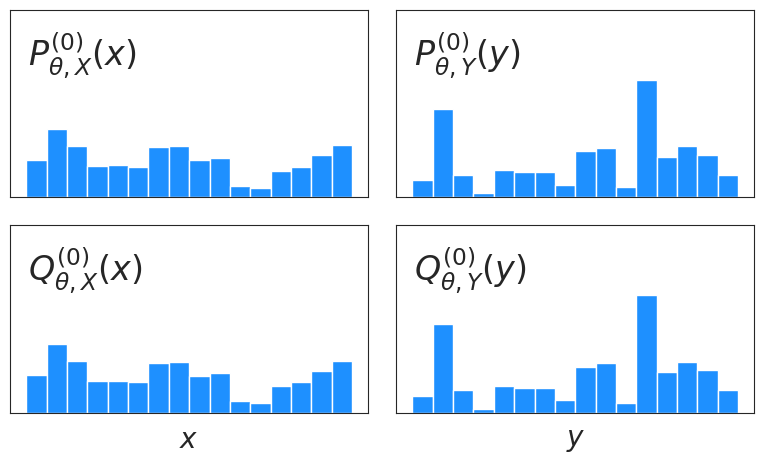

In [6]:
m1x, m1y, m2x, m2y = get_marginals(*jointly_centered_loss(logits))

sns.set_style("white")
    
fig, axes = plt.subplots(2, 2, figsize=(8, 5), sharex=True, sharey="row")
ticks = torch.arange(len(m1x))

axes[0, 0].bar(ticks, m1x, color=color, width=width)
axes[0, 1].bar(ticks, m1y, color=color, width=width)
axes[1, 0].bar(ticks, m2x, color=color, width=width)
axes[1, 1].bar(ticks, m2y, color=color, width=width)

ms = [m1x, m1y, m2x, m2y]
for i, ax in enumerate([axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]]):
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_ylim(0.0, 5 * torch.mean(ms[i]))

labelpad = -24.0
coords = (0.05, 0.7)
axes[0, 0].text(*coords, r"$P^{(0)}_{\theta, X}(x)$", transform=axes[0, 0].transAxes, fontsize=fontsize)
axes[0, 1].text(*coords, r"$P^{(0)}_{\theta, Y}(y)$", transform=axes[0, 1].transAxes, fontsize=fontsize)
axes[1, 0].text(*coords, r"$Q^{(0)}_{\theta, X}(x)$", transform=axes[1, 0].transAxes, fontsize=fontsize)
axes[1, 1].text(*coords, r"$Q^{(0)}_{\theta, Y}(y)$", transform=axes[1, 1].transAxes, fontsize=fontsize)

axes[1, 0].set_xlabel(r"$x$")
axes[1, 1].set_xlabel(r"$y$")

fig.tight_layout(pad=2.0)

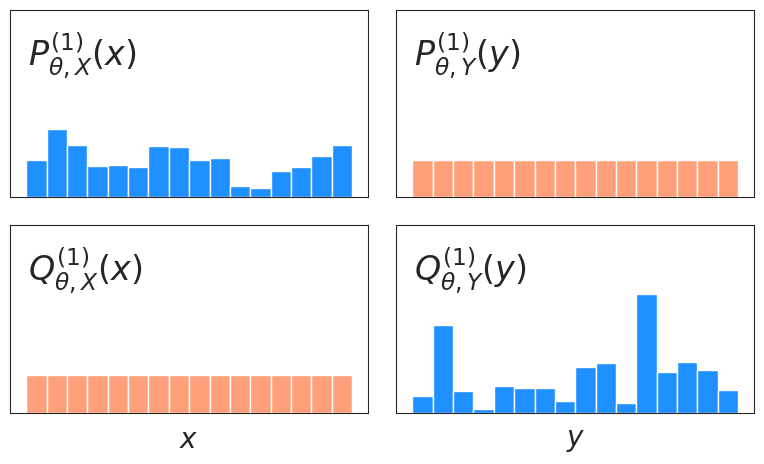

In [7]:
m1x, m1y, m2x, m2y = get_marginals(*clip_loss(logits))

sns.set_style("white")
    
fig, axes = plt.subplots(2, 2, figsize=(8, 5), sharex=True, sharey="row")
ticks = torch.arange(len(m1x))

axes[0, 0].bar(ticks, m1x, color=color, width=width)
axes[0, 1].bar(ticks, m1y, color=color2, width=width)
axes[1, 0].bar(ticks, m2x, color=color2, width=width)
axes[1, 1].bar(ticks, m2y, color=color, width=width)

ms = [m1x, m1y, m2x, m2y]
for i, ax in enumerate([axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]]):
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_ylim(0.0, 5 * torch.mean(ms[i]))

labelpad = -24.0
coords = (0.05, 0.7)
axes[0, 0].text(*coords, r"$P^{(1)}_{\theta, X}(x)$", transform=axes[0, 0].transAxes, fontsize=fontsize)
axes[0, 1].text(*coords, r"$P^{(1)}_{\theta, Y}(y)$", transform=axes[0, 1].transAxes, fontsize=fontsize)
axes[1, 0].text(*coords, r"$Q^{(1)}_{\theta, X}(x)$", transform=axes[1, 0].transAxes, fontsize=fontsize)
axes[1, 1].text(*coords, r"$Q^{(1)}_{\theta, Y}(y)$", transform=axes[1, 1].transAxes, fontsize=fontsize)

axes[1, 0].set_xlabel(r"$x$")
axes[1, 1].set_xlabel(r"$y$")

fig.tight_layout(pad=2.0)

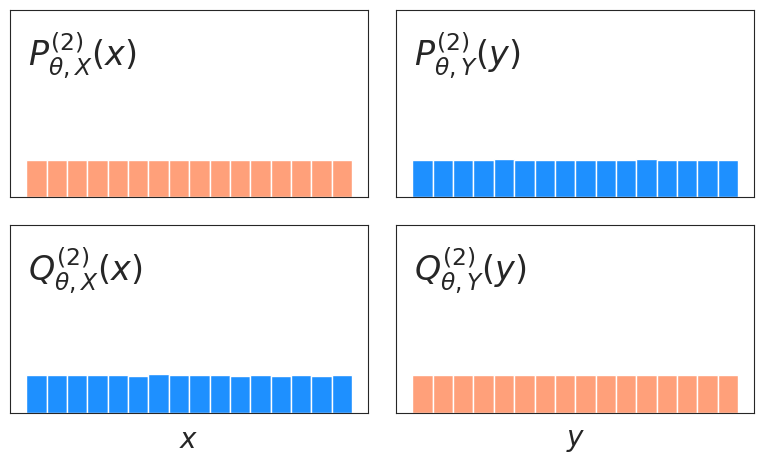

In [8]:
m1x, m1y, m2x, m2y = get_marginals(*doubly_centered_loss(logits))

sns.set_style("white")
    
fig, axes = plt.subplots(2, 2, figsize=(8, 5), sharex=True, sharey="row")
ticks = torch.arange(len(m1x))

axes[0, 0].bar(ticks, m1x, color=color2, width=width)
axes[0, 1].bar(ticks, m1y, color=color, width=width)
axes[1, 0].bar(ticks, m2x, color=color, width=width)
axes[1, 1].bar(ticks, m2y, color=color2, width=width)

ms = [m1x, m1y, m2x, m2y]
for i, ax in enumerate([axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]]):
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_ylim(0.0, 5 * torch.mean(ms[i]))

labelpad = -24.0
coords = (0.05, 0.7)
axes[0, 0].text(*coords, r"$P^{(2)}_{\theta, X}(x)$", transform=axes[0, 0].transAxes, fontsize=fontsize)
axes[0, 1].text(*coords, r"$P^{(2)}_{\theta, Y}(y)$", transform=axes[0, 1].transAxes, fontsize=fontsize)
axes[1, 0].text(*coords, r"$Q^{(2)}_{\theta, X}(x)$", transform=axes[1, 0].transAxes, fontsize=fontsize)
axes[1, 1].text(*coords, r"$Q^{(2)}_{\theta, Y}(y)$", transform=axes[1, 1].transAxes, fontsize=fontsize)

axes[1, 0].set_xlabel(r"$x$")
axes[1, 1].set_xlabel(r"$y$")

fig.tight_layout(pad=2.0)